<a href="https://colab.research.google.com/github/marimontal/Personal/blob/main/Reforma_a_Vapor_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importação das Bibliotecas


In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from tensorflow import keras
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
from sklearn.metrics import r2_score


In [4]:
!pip install optuna

In [5]:
import optuna

# Importação dos Dados

In [6]:
dados1=pd.read_csv('/content/drive/MyDrive/IC/dados_perturbados2.csv')

In [7]:
del dados1['Unnamed: 0']

In [8]:
dados1.head(5)

FH20  FCO20/FCH40            P0  ...          P          FCH4      FCO2
0  0.615458     0.061678  3.113332e+06  ...  23.389780  1.191061e+00  4.725675
1  0.637704     0.054970  2.940561e+06  ...  19.088024  2.692550e+00  3.438978
2  0.600836     0.064120  2.634352e+06  ...  23.441212  2.755359e-01  6.074142
3  0.655176     0.063134  3.131069e+06  ...  22.932162  3.417445e-08  5.606041
4  0.603690     0.063664  2.724111e+06  ...  24.377912  8.721188e-01  4.739813

[5 rows x 11 columns]

# Divisão dos dados

In [9]:
def dividir_X_Y(df,saida):
    entrada = list(df.columns)
    for el in saida:
        if el in entrada:
            entrada.remove(el)
    Y = df.drop(entrada,axis=1)
    X = df.drop(saida,axis=1)
    return X,Y

# Separação em Treino, Teste e Validação

In [10]:
def separacao(X,Y,perc_teste,perc_val):
    # Teste
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size = perc_teste)  
    
    #Treino e Validação
    X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size = perc_val) 
    return X_train, X_test,X_val, Y_train, Y_test, Y_val

# Normalização das entradas

In [11]:
def normaliza(x_train,x_val,x_test):

    preprocessParams = preprocessing.StandardScaler().fit(x_train)

    X_train_norm = preprocessParams.transform(x_train)
    X_val_norm = preprocessParams.transform(x_val)
    X_test_norm = preprocessParams.transform(x_test)

    return X_train_norm, X_val_norm, X_test_norm

# Funções

## Função de aprendizagem

In [12]:
def aprendizagem(m,score,lb,ub):
    # calculando a curva de aprendizado!
    train_sizes, train_scores, test_scores = learning_curve(m,X_Train, Y_Train, 
                                                        scoring = score)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(test_scores, axis=1)
    val_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label="Treino")
    plt.plot(train_sizes, val_scores_mean, label="Validacao")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                                   train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                                   val_scores_mean + val_scores_std, alpha=0.1)
    plt.legend()
    plt.xlabel('Número de amostras de treino')
    plt.ylabel(score)
    
    plt.ylim([lb,ub])

# Auto Machine Learning

## Função: Objetivo

In [13]:
def objetivo_reg(trial):    
    global R2train

    # hiperparâmetros de busca para o xgboost
    xg_n_estimator = trial.suggest_int("xg_n_estimators", 50, 200)
    xg_max_depth = trial.suggest_int("xg_max_depth", 2, 32, log = True)
    
    #Modelo Regressão
    num_rounds = 20
    m = xgb.XGBRegressor(n_estimators=xg_n_estimator,max_depth=xg_max_depth)
    eval_set = [(X_Train, Y_Train), (X_Val, Y_Val)]
    m.fit(X_Train, Y_Train,early_stopping_rounds=num_rounds, eval_metric=["error", 'mae',"rmse"], eval_set=eval_set)
    
    Y_Val_pred = m.predict(X_Val)
    Y_Train_pred = m.predict(X_Train)
    
    # Retornando R2
    R2train.append(sklearn.metrics.r2_score(Y_Train,Y_Train_pred))
    r2val = sklearn.metrics.r2_score(Y_Val,Y_Val_pred)
    
    return r2val

## Função: Otimiza

In [14]:
def otimiza(trials):
    global R2train
    # Criando objeto da classe Study usando a função creat_study
    study = optuna.create_study(direction="maximize")
    R2train =[]

    # Fornecendo a função objetivo ao método optmize
    study.optimize(objetivo_reg, n_trials = trials)
    return study

## Função: Melhor Modelo

In [15]:
def melhor_modelo(study):
    
    m = xgb.XGBRegressor(n_estimators=study.best_params['xg_n_estimators'],max_depth=study.best_params['xg_max_depth'])
    eval_set = [(X_Train, Y_Train), (X_Val, Y_Val)]
    num_rounds = 10
    m.fit(X_Train, Y_Train,early_stopping_rounds=num_rounds, eval_metric=["error", 'mae',"rmse"], eval_set=eval_set)
    '''
    # caso a gente queira fazer validacao cruzada *****
    from sklearn.model_selection import cross_val_score, cross_validate
    from sklearn.model_selection import KFold
    Xnovo = np.concatenate((X_train_norm,X_val_norm),axis = 0)
    Ynovo = np.concatenate((Y_train,Y_val),axis = 0)
    kfold = KFold(n_splits=5)
    results = cross_val_score(m, Xnovo, Ynovo, cv=kfold, scoring = "r2")
    results.mean()*100, results.std()*100)
    '''
    Y_train_pred = m.predict(X_Train)
    Y_val_pred = m.predict(X_Val)
    Y_test_pred = m.predict(X_Test)
    return m,Y_train_pred,Y_val_pred,Y_test_pred

# Desempenho do Modelo

In [16]:
def desempenho(Y_train, Y_train_pred,Y_val, Y_val_pred, Y_test, Y_test_pred):
    MAEtrain = sklearn.metrics.mean_absolute_error(Y_train, Y_train_pred)
    r2train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
    MSEtrain = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
    RMSEtrain = np.sqrt(MSEtrain)
    #nn = len(Y_train)    PERGUNTAR PARA O Q SERVE!!!!
    #pp = Y_train.shape[1]
    #r2trainad = 1-(1-r2train)*(nn-1)/(nn - pp - 1)

    MAEval = sklearn.metrics.mean_absolute_error(Y_val, Y_val_pred)
    r2val = sklearn.metrics.r2_score(Y_val, Y_val_pred)
    MSEval = sklearn.metrics.mean_squared_error(Y_val, Y_val_pred)
    RMSEval = np.sqrt(MSEval)
    #nn = len(Y_val)
    #pp = Y_val.shape[1]
    #r2valad = 1-(1-r2val)*(nn-1)/(nn - pp - 1)

    MAEtest = sklearn.metrics.mean_absolute_error(Y_test, Y_test_pred)
    r2test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
    MSEtest = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
    RMSEtest = np.sqrt(MSEtest)
    #nn = len(Y_test)
    #pp = Y_test.shape[1]

    #r2testad = 1-(1-r2test)*(nn-1)/(nn - pp - 1)

    saida = pd.DataFrame({'MAE':[MAEtrain,MAEval,MAEtest],'R2':[r2train,r2val,r2test],
                           'MSE':[MSEtrain,MSEval,MSEtest],
                          'RMSE':[RMSEtrain,RMSEval,RMSEtest]},
                        index = ['Train','Validation','Test'])
    return saida

# Interpretação do Modelo

## Função: Importância das variáveis

In [17]:
def importancia(feature_list,m,nout):
    importances = list(m.feature_importances_)
    n = len(feature_list)
    df_ipc = pd.DataFrame({'importancia':importances},index = feature_list)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plt.ylabel('Importância'); plt.xlabel('Variável'); plt.title('Importância das variáveis');
    plt.show()
    
    return df_ipc

# Função: Contribuição das Variáveis

In [18]:
def contribuicao(m,ytrain,xval):
    row = xval[np.newaxis,0]
    #m.fit(X_train, ytrain)
    prediction, bias, contributions = ti.predict(m, row)
    print(contributions)
    idxs = np.argsort(contributions[0])
    [o for o in zip(xval.columns[idxs], xval.iloc[0][idxs], contributions[0][idxs])]
    waterfall_chart.plot(xval.columns, contributions[0],  threshold=0.08,
                     rotation_value=90,formatting='{:,.3f}');
    plt.show()

# Modelos

## Modelo 1 - XGBoost

In [20]:
label_dados = list(dados1.columns)

In [21]:
saida_dados = list(dados1[label_dados[4:]].columns)
saida_dados

['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2']

In [22]:
# Dividindo os dados
X,Y = dividir_X_Y(dados1,saida_dados)


In [23]:
Y.columns


Index(['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2'], dtype='object')

In [24]:
Y = Y['FH2w']


In [25]:
#Separação de Treino, teste e validação
X_Train,X_Test,X_Val,Y_Train,Y_Test,Y_Val = separacao(X,Y,0.1,0.2)

In [26]:
X_Train = X_Train.reset_index(drop=True)
X_Val = X_Val.reset_index(drop=True)
X_Test = X_Test.reset_index(drop=True)
Y_Train = Y_Train.reset_index(drop=True)
Y_Val = Y_Val.reset_index(drop=True)
Y_Test = Y_Test.reset_index(drop=True)

In [27]:
Y_Test

0       19.956797
1       24.714849
2       25.367083
3       21.322568
4       22.690831
          ...    
1634    21.255754
1635    12.088833
1636    20.605559
1637    22.667020
1638    19.066699
Name: FH2w, Length: 1639, dtype: float64

In [ ]:
X_Train_norm, X_Val_norm, X_Test_norm = normaliza(X_Train, X_Val, X_Test)

In [ ]:
X_Train_norm 

array([[ 1.13649057, -0.90677228, -1.25464349,  0.3755963 ],
       [ 0.45836968,  0.68992459,  0.8800835 ,  2.09461887],
       [-1.6607734 ,  0.19103464,  0.43328609,  1.3632063 ],
       ...,
       [ 0.12554714,  0.4718277 , -0.26887105, -0.50180063],
       [-0.38946329,  0.54804293, -0.67823426, -1.11359936],
       [ 0.88942308, -0.59674132,  0.30774665, -0.1474629 ]])

In [ ]:
X_Train_norm.shape 

(11796, 4)

In [28]:
study = otimiza(100)

[I 2021-05-14 05:45:15,610] A new study created in memory with name: no-name-016fb477-eb5b-4cb3-adff-cf808d736c78


[05:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1231	validation_0-rmse:14.8316	validation_1-error:-18.9969	validation_1-mae:14.2436	validation_1-rmse:14.9318
[3]	validation_0-error:-18.8646	validation_0-mae:12.7142	validation_0-rmse:13.4799	validation_1-error:-18.9969	validation_1-mae:12.8336	validation_1-rmse:13.5798
[4]	validation_0-error:-18.8646	validation_0-mae:11.4474	validation_

[I 2021-05-14 05:45:18,870] Trial 0 finished with value: 0.09126760368775277 and parameters: {'xg_n_estimators': 134, 'xg_max_depth': 20}. Best is trial 0 with value: 0.09126760368775277.


[05:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6894	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.8123	validation_1-rmse:16.4483
[2]	validation_0-error:-18.8646	validation_0-mae:14.1224	validation_0-rmse:14.8318	validation_1-error:-18.9969	validation_1-mae:14.242	validation_1-rmse:14.9305
[3]	validation_0-error:-18.8646	validation_0-mae:12.7125	validation_0-rmse:13.4807	validation_1-error:-18.9969	validation_1-mae:12.8289	validation_1-rmse:13.5759
[4]	validation_0-error:-18.8646	validation_0-mae:11.4433	validation_

[I 2021-05-14 05:45:20,029] Trial 1 finished with value: 0.15448425318717307 and parameters: {'xg_n_estimators': 51, 'xg_max_depth': 6}. Best is trial 1 with value: 0.15448425318717307.


[05:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:45:22,263] Trial 2 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 175, 'xg_max_depth': 3}. Best is trial 2 with value: 0.1612059825214991.


[05:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1231	validation_0-rmse:14.8316	validation_1-error:-18.9969	validation_1-mae:14.2436	validation_1-rmse:14.9318
[3]	validation_0-error:-18.8646	validation_0-mae:12.7142	validation_0-rmse:13.4799	validation_1-error:-18.9969	validation_1-mae:12.8336	validation_1-rmse:13.5798
[4]	validation_0-error:-18.8646	validation_0-mae:11.4474	validation_

[I 2021-05-14 05:45:26,189] Trial 3 finished with value: 0.07104092328453515 and parameters: {'xg_n_estimators': 78, 'xg_max_depth': 26}. Best is trial 2 with value: 0.1612059825214991.


[05:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6894	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.8123	validation_1-rmse:16.4483
[2]	validation_0-error:-18.8646	validation_0-mae:14.1224	validation_0-rmse:14.8318	validation_1-error:-18.9969	validation_1-mae:14.242	validation_1-rmse:14.9305
[3]	validation_0-error:-18.8646	validation_0-mae:12.7125	validation_0-rmse:13.4807	validation_1-error:-18.9969	validation_1-mae:12.8289	validation_1-rmse:13.5759
[4]	validation_0-error:-18.8646	validation_0-mae:11.4433	validation_

[I 2021-05-14 05:45:28,041] Trial 4 finished with value: 0.15508102411250568 and parameters: {'xg_n_estimators': 164, 'xg_max_depth': 6}. Best is trial 2 with value: 0.1612059825214991.


[05:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1231	validation_0-rmse:14.8316	validation_1-error:-18.9969	validation_1-mae:14.2436	validation_1-rmse:14.9318
[3]	validation_0-error:-18.8646	validation_0-mae:12.7142	validation_0-rmse:13.48	validation_1-error:-18.9969	validation_1-mae:12.8334	validation_1-rmse:13.5797
[4]	validation_0-error:-18.8646	validation_0-mae:11.4467	validation_0-

[I 2021-05-14 05:45:29,918] Trial 5 finished with value: 0.13981687470345994 and parameters: {'xg_n_estimators': 187, 'xg_max_depth': 10}. Best is trial 2 with value: 0.1612059825214991.


[05:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1231	validation_0-rmse:14.8316	validation_1-error:-18.9969	validation_1-mae:14.2436	validation_1-rmse:14.9318
[3]	validation_0-error:-18.8646	validation_0-mae:12.7142	validation_0-rmse:13.4799	validation_1-error:-18.9969	validation_1-mae:12.8336	validation_1-rmse:13.5798
[4]	validation_0-error:-18.8646	validation_0-mae:11.4474	validation_

[I 2021-05-14 05:45:33,896] Trial 6 finished with value: 0.07104092328453515 and parameters: {'xg_n_estimators': 100, 'xg_max_depth': 26}. Best is trial 2 with value: 0.1612059825214991.


[05:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:45:36,312] Trial 7 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 198, 'xg_max_depth': 3}. Best is trial 2 with value: 0.1612059825214991.


[05:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1228	validation_0-rmse:14.8317	validation_1-error:-18.9969	validation_1-mae:14.2433	validation_1-rmse:14.9317
[3]	validation_0-error:-18.8646	validation_0-mae:12.7136	validation_0-rmse:13.4801	validation_1-error:-18.9969	validation_1-mae:12.8329	validation_1-rmse:13.5794
[4]	validation_0-error:-18.8646	validation_0-mae:11.4454	validation_

[I 2021-05-14 05:45:38,181] Trial 8 finished with value: 0.15224629945114065 and parameters: {'xg_n_estimators': 87, 'xg_max_depth': 8}. Best is trial 2 with value: 0.1612059825214991.


[05:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:39,646] Trial 9 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 195, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:41,122] Trial 10 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 146, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:42,627] Trial 11 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 143, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:44,135] Trial 12 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 155, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:45,682] Trial 13 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 115, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:45:48,177] Trial 14 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 191, 'xg_max_depth': 3}. Best is trial 9 with value: 0.16130564733503805.


[05:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:49,730] Trial 15 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 155, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4296	validation_0-rmse:18.0406	validation_1-error:-18.9969	validation_1-mae:17.5565	validation_1-rmse:18.1472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.688	validation_0-rmse:16.3469	validation_1-error:-18.9969	validation_1-mae:15.8083	validation_1-rmse:16.4467
[2]	validation_0-error:-18.8646	validation_0-mae:14.1203	validation_0-rmse:14.8334	validation_1-error:-18.9969	validation_1-mae:14.2373	validation_1-rmse:14.9289
[3]	validation_0-error:-18.8646	validation_0-mae:12.7095	validation_0-rmse:13.4833	validation_1-error:-18.9969	validation_1-mae:12.8233	validation_1-rmse:13.5742
[4]	validation_0-error:-18.8646	validation_0-mae:11.4396	validation

[I 2021-05-14 05:45:51,439] Trial 16 finished with value: 0.16021419702515005 and parameters: {'xg_n_estimators': 122, 'xg_max_depth': 4}. Best is trial 9 with value: 0.16130564733503805.


[05:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4296	validation_0-rmse:18.0406	validation_1-error:-18.9969	validation_1-mae:17.5565	validation_1-rmse:18.1472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.688	validation_0-rmse:16.3469	validation_1-error:-18.9969	validation_1-mae:15.8083	validation_1-rmse:16.4467
[2]	validation_0-error:-18.8646	validation_0-mae:14.1203	validation_0-rmse:14.8334	validation_1-error:-18.9969	validation_1-mae:14.2373	validation_1-rmse:14.9289
[3]	validation_0-error:-18.8646	validation_0-mae:12.7095	validation_0-rmse:13.4833	validation_1-error:-18.9969	validation_1-mae:12.8233	validation_1-rmse:13.5742
[4]	validation_0-error:-18.8646	validation_0-mae:11.4396	validation

[I 2021-05-14 05:45:53,191] Trial 17 finished with value: 0.16021419702515005 and parameters: {'xg_n_estimators': 116, 'xg_max_depth': 4}. Best is trial 9 with value: 0.16130564733503805.


[05:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:45:54,760] Trial 18 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 114, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4302	validation_0-rmse:18.0402	validation_1-error:-18.9969	validation_1-mae:17.5569	validation_1-rmse:18.1467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6892	validation_0-rmse:16.346	validation_1-error:-18.9969	validation_1-mae:15.812	validation_1-rmse:16.4482
[2]	validation_0-error:-18.8646	validation_0-mae:14.1231	validation_0-rmse:14.8316	validation_1-error:-18.9969	validation_1-mae:14.2436	validation_1-rmse:14.9318
[3]	validation_0-error:-18.8646	validation_0-mae:12.7142	validation_0-rmse:13.4799	validation_1-error:-18.9969	validation_1-mae:12.8336	validation_1-rmse:13.5798
[4]	validation_0-error:-18.8646	validation_0-mae:11.4474	validation_

[I 2021-05-14 05:45:57,286] Trial 19 finished with value: 0.1335569093750394 and parameters: {'xg_n_estimators': 174, 'xg_max_depth': 13}. Best is trial 9 with value: 0.16130564733503805.


[05:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4296	validation_0-rmse:18.0406	validation_1-error:-18.9969	validation_1-mae:17.5565	validation_1-rmse:18.1472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.688	validation_0-rmse:16.3469	validation_1-error:-18.9969	validation_1-mae:15.8083	validation_1-rmse:16.4467
[2]	validation_0-error:-18.8646	validation_0-mae:14.1203	validation_0-rmse:14.8334	validation_1-error:-18.9969	validation_1-mae:14.2373	validation_1-rmse:14.9289
[3]	validation_0-error:-18.8646	validation_0-mae:12.7095	validation_0-rmse:13.4833	validation_1-error:-18.9969	validation_1-mae:12.8233	validation_1-rmse:13.5742
[4]	validation_0-error:-18.8646	validation_0-mae:11.4396	validation

[I 2021-05-14 05:45:58,651] Trial 20 finished with value: 0.16021419702515005 and parameters: {'xg_n_estimators': 63, 'xg_max_depth': 4}. Best is trial 9 with value: 0.16130564733503805.


[05:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:00,248] Trial 21 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 147, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:01,832] Trial 22 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 137, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:03,452] Trial 23 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 103, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:05,064] Trial 24 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 134, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:06,677] Trial 25 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 159, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:08,336] Trial 26 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 99, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:09,972] Trial 27 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 107, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:11,627] Trial 28 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 130, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:46:14,285] Trial 29 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 127, 'xg_max_depth': 3}. Best is trial 9 with value: 0.16130564733503805.


[05:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:15,953] Trial 30 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 90, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:17,625] Trial 31 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 102, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:19,025] Trial 32 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 70, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:20,397] Trial 33 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 69, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:21,643] Trial 34 finished with value: 0.16079995074132547 and parameters: {'xg_n_estimators': 64, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:46:24,551] Trial 35 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 3}. Best is trial 9 with value: 0.16130564733503805.


[05:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:26,286] Trial 36 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 156, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:27,355] Trial 37 finished with value: 0.15900482720937048 and parameters: {'xg_n_estimators': 51, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:29,103] Trial 38 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 92, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:30,694] Trial 39 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 80, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:32,429] Trial 40 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 86, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:34,145] Trial 41 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 98, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:35,940] Trial 42 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 88, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:37,755] Trial 43 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 134, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:39,566] Trial 44 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 182, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4291	validation_0-rmse:18.042	validation_1-error:-18.9969	validation_1-mae:17.5582	validation_1-rmse:18.1503
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6871	validation_0-rmse:16.3488	validation_1-error:-18.9969	validation_1-mae:15.8099	validation_1-rmse:16.4501
[2]	validation_0-error:-18.8646	validation_0-mae:14.1192	validation_0-rmse:14.8361	validation_1-error:-18.9969	validation_1-mae:14.2369	validation_1-rmse:14.932
[3]	validation_0-error:-18.8646	validation_0-mae:12.7081	validation_0-rmse:13.4869	validation_1-error:-18.9969	validation_1-mae:12.8244	validation_1-rmse:13.5795
[4]	validation_0-error:-18.8646	validation_0-mae:11.4379	validation_

[I 2021-05-14 05:46:42,569] Trial 45 finished with value: 0.1612059825214991 and parameters: {'xg_n_estimators': 163, 'xg_max_depth': 3}. Best is trial 9 with value: 0.16130564733503805.


[05:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:44,346] Trial 46 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 121, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:46,225] Trial 47 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 109, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:47,946] Trial 48 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 120, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:49,903] Trial 49 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 108, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:51,835] Trial 50 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 121, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:53,790] Trial 51 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 108, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:55,750] Trial 52 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 94, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:57,558] Trial 53 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 104, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:46:59,444] Trial 54 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 96, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:01,143] Trial 55 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 75, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:02,903] Trial 56 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 83, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:04,302] Trial 57 finished with value: 0.16099039966699324 and parameters: {'xg_n_estimators': 65, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:06,187] Trial 58 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 129, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:08,070] Trial 59 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 134, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:09,867] Trial 60 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 138, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:11,405] Trial 61 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 69, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:12,961] Trial 62 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 75, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:14,251] Trial 63 finished with value: 0.15996568871611572 and parameters: {'xg_n_estimators': 58, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:15,915] Trial 64 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 76, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:17,756] Trial 65 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 82, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:18,985] Trial 66 finished with value: 0.15988725896856393 and parameters: {'xg_n_estimators': 57, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:20,745] Trial 67 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 79, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:22,257] Trial 68 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 69, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:23,795] Trial 69 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 70, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:25,293] Trial 70 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 72, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:27,196] Trial 71 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 91, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:29,111] Trial 72 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 104, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:30,938] Trial 73 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 177, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:32,784] Trial 74 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 150, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:34,797] Trial 75 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 181, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:36,611] Trial 76 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 84, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:38,634] Trial 77 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 95, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:40,476] Trial 78 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 113, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:42,352] Trial 79 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 109, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:44,288] Trial 80 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 97, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:46,268] Trial 81 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 122, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:48,135] Trial 82 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 87, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:50,124] Trial 83 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 94, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:52,135] Trial 84 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 127, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:54,140] Trial 85 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:56,018] Trial 86 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 144, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:57,922] Trial 87 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 131, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:47:59,821] Trial 88 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 135, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:01,478] Trial 89 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 75, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:03,247] Trial 90 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 76, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:05,102] Trial 91 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 166, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:06,909] Trial 92 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 169, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:08,303] Trial 93 finished with value: 0.160612670573688 and parameters: {'xg_n_estimators': 61, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:10,201] Trial 94 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 116, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:11,824] Trial 95 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 71, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:13,398] Trial 96 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 68, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:15,207] Trial 97 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 80, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:16,439] Trial 98 finished with value: 0.15928538486603727 and parameters: {'xg_n_estimators': 52, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


[05:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

[I 2021-05-14 05:48:18,416] Trial 99 finished with value: 0.16130564733503805 and parameters: {'xg_n_estimators': 150, 'xg_max_depth': 2}. Best is trial 9 with value: 0.16130564733503805.


In [30]:
optuna.visualization.plot_optimization_history(study)

In [33]:
m,Y_Train_pred,Y_Val_pred,Y_Test_pred =  melhor_modelo(study)

[05:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-18.8646	validation_0-mae:17.4288	validation_0-rmse:18.0437	validation_1-error:-18.9969	validation_1-mae:17.5574	validation_1-rmse:18.1513
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-error:-18.8646	validation_0-mae:15.6865	validation_0-rmse:16.3532	validation_1-error:-18.9969	validation_1-mae:15.8103	validation_1-rmse:16.455
[2]	validation_0-error:-18.8646	validation_0-mae:14.1184	validation_0-rmse:14.8429	validation_1-error:-18.9969	validation_1-mae:14.2393	validation_1-rmse:14.9404
[3]	validation_0-error:-18.8646	validation_0-mae:12.7071	validation_0-rmse:13.4961	validation_1-error:-18.9969	validation_1-mae:12.8239	validation_1-rmse:13.5881
[4]	validation_0-error:-18.8646	validation_0-mae:11.4368	validation

In [34]:
a = desempenho(Y_Train, Y_Train_pred,Y_Val, Y_Val_pred, Y_Test, Y_Test_pred)
a

MAE        R2        MSE      RMSE
Train       3.565741  0.182223  18.290444  4.276733
Validation  3.559378  0.161306  18.207222  4.266992
Test        3.637810  0.171064  18.979546  4.356552

Keagle:
https://www.kaggle.com/questions-and-answers/54290
https://www.kaggle.com/dansbecker/xgboost
https://www.kaggle.com/dlarionov/feature-engineering-xgboost


[05:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

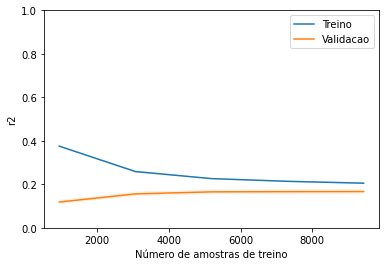

In [38]:
aprendizagem(xgb.XGBRegressor(n_estimators=study.best_params['xg_n_estimators'],max_depth=study.best_params['xg_max_depth']),'r2',0,1)

Variable: T0                   Importance: 0.7099999785423279
Variable: P0                   Importance: 0.18000000715255737
Variable: FCO20/FCH40          Importance: 0.05999999865889549
Variable: FH20                 Importance: 0.05000000074505806


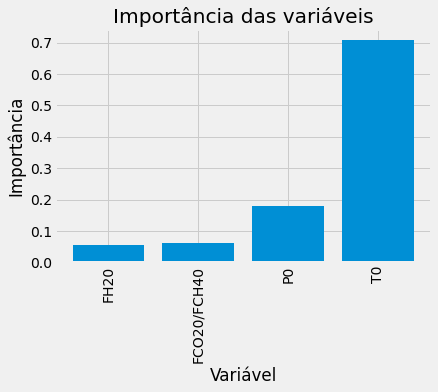

importancia
FH20            0.053879
FCO20/FCH40     0.060184
P0              0.178369
T0              0.707569

In [40]:
df_ipc = importancia(list(X.columns),m,Y)
df_ipc

Resumo: desempenho péssimo.
Temperatura é uma variável de muita importância.

## Modelo 2 - XGBoost 

In [29]:
label_dados = list(dados1.columns)


In [30]:
saida_dados = list(dados1[label_dados[4:]].columns)
saida_dados

['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2']

In [31]:
# Dividindo os dados
X,Y = dividir_X_Y(dados1,saida_dados)
Y.columns

Index(['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2'], dtype='object')

In [32]:
Y = Y['FCH4']
Y

0        1.191061e+00
1        2.692550e+00
2        2.755359e-01
3        3.417445e-08
4        8.721188e-01
             ...     
16379    3.964428e-05
16380    1.558795e+00
16381    2.818645e+00
16382    3.969487e-01
16383    8.003488e-07
Name: FCH4, Length: 16384, dtype: float64

In [33]:
#Separação de Treino, teste e validação
X_Train,X_Test,X_Val,Y_Train,Y_Test,Y_Val = separacao(X,Y,0.1,0.2)

In [34]:
X_Train = X_Train.reset_index(drop=True)
X_Val = X_Val.reset_index(drop=True)
X_Test = X_Test.reset_index(drop=True)
Y_Train = Y_Train.reset_index(drop=True)
Y_Val = Y_Val.reset_index(drop=True)
Y_Test = Y_Test.reset_index(drop=True)

In [35]:
study = otimiza(100)


[I 2021-05-14 06:13:06,066] A new study created in memory with name: no-name-1dacbb7b-74e5-49ce-80eb-b0a67fde9493


[06:13:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.254299	validation_0-mae:0.961332	validation_0-rmse:1.27204	validation_1-error:-0.217874	validation_1-mae:0.96421	validation_1-rmse:1.26971
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.252627	validation_0-mae:0.934823	validation_0-rmse:1.22682	validation_1-error:-0.233316	validation_1-mae:0.939422	validation_1-rmse:1.22768
[2]	validation_0-error:-0.253632	validation_0-mae:0.912283	validation_0-rmse:1.18852	validation_1-error:-0.2344	validation_1-mae:0.919636	validation_1-rmse:1.19342
[3]	validation_0-error:-0.252894	validation_0-mae:0.893589	validation_0-rmse:1.15617	validation_1-error:-0.23782	validation_1-mae:0.903904	validation_1-rmse:1.1648
[4]	validation_0-error:-0.25356	validation_0-mae:0.8781

[I 2021-05-14 06:13:07,300] Trial 0 finished with value: 0.15040399327685572 and parameters: {'xg_n_estimators': 133, 'xg_max_depth': 8}. Best is trial 0 with value: 0.15040399327685572.


[06:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.415092	validation_0-mae:0.926069	validation_0-rmse:1.23741	validation_1-error:0.071642	validation_1-mae:0.964947	validation_1-rmse:1.27371
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.3893	validation_0-mae:0.869671	validation_0-rmse:1.16067	validation_1-error:-0.048355	validation_1-mae:0.941903	validation_1-rmse:1.23724
[2]	validation_0-error:-0.390437	validation_0-mae:0.81638	validation_0-rmse:1.08907	validation_1-error:-0.089135	validation_1-mae:0.92434	validation_1-rmse:1.20849
[3]	validation_0-error:-0.39493	validation_0-mae:0.766437	validation_0-rmse:1.02246	validation_1-error:-0.093013	validation_1-mae:0.913509	validation_1-rmse:1.18564
[4]	validation_0-error:-0.387506	validation_0-mae:0.7242

[I 2021-05-14 06:13:09,519] Trial 1 finished with value: 0.04304046569112141 and parameters: {'xg_n_estimators': 95, 'xg_max_depth': 22}. Best is trial 0 with value: 0.15040399327685572.


[06:13:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.259866	validation_0-mae:0.96015	validation_0-rmse:1.2709	validation_1-error:-0.208692	validation_1-mae:0.964517	validation_1-rmse:1.26989
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.259359	validation_0-mae:0.932742	validation_0-rmse:1.22462	validation_1-error:-0.21961	validation_1-mae:0.939874	validation_1-rmse:1.22853
[2]	validation_0-error:-0.259172	validation_0-mae:0.909103	validation_0-rmse:1.18544	validation_1-error:-0.231657	validation_1-mae:0.919852	validation_1-rmse:1.19437
[3]	validation_0-error:-0.259042	validation_0-mae:0.889	validation_0-rmse:1.15154	validation_1-error:-0.234316	validation_1-mae:0.904555	validation_1-rmse:1.16582
[4]	validation_0-error:-0.25895	validation_0-mae:0.87215

[I 2021-05-14 06:13:10,842] Trial 2 finished with value: 0.14621330072734717 and parameters: {'xg_n_estimators': 150, 'xg_max_depth': 9}. Best is trial 0 with value: 0.15040399327685572.


[06:13:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.274078	validation_0-mae:0.957385	validation_0-rmse:1.26808	validation_1-error:-0.189938	validation_1-mae:0.964504	validation_1-rmse:1.27026
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.273211	validation_0-mae:0.926601	validation_0-rmse:1.21881	validation_1-error:-0.21131	validation_1-mae:0.939757	validation_1-rmse:1.22961
[2]	validation_0-error:-0.271005	validation_0-mae:0.899761	validation_0-rmse:1.17605	validation_1-error:-0.226916	validation_1-mae:0.920334	validation_1-rmse:1.19633
[3]	validation_0-error:-0.270075	validation_0-mae:0.875902	validation_0-rmse:1.13851	validation_1-error:-0.231485	validation_1-mae:0.905742	validation_1-rmse:1.16893
[4]	validation_0-error:-0.269549	validation_0-mae:0

[I 2021-05-14 06:13:12,229] Trial 3 finished with value: 0.1317193606924536 and parameters: {'xg_n_estimators': 63, 'xg_max_depth': 11}. Best is trial 0 with value: 0.15040399327685572.


[06:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:13,252] Trial 4 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 126, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:14,243] Trial 5 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 86, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.453349	validation_0-mae:0.91881	validation_0-rmse:1.23073	validation_1-error:0.135665	validation_1-mae:0.965729	validation_1-rmse:1.27504
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.427948	validation_0-mae:0.855851	validation_0-rmse:1.14739	validation_1-error:0.001482	validation_1-mae:0.944192	validation_1-rmse:1.24102
[2]	validation_0-error:-0.433197	validation_0-mae:0.797461	validation_0-rmse:1.07016	validation_1-error:-0.03728	validation_1-mae:0.930358	validation_1-rmse:1.21499
[3]	validation_0-error:-0.439771	validation_0-mae:0.739427	validation_0-rmse:0.995236	validation_1-error:-0.060022	validation_1-mae:0.917987	validation_1-rmse:1.19321
[4]	validation_0-error:-0.44186	validation_0-mae:0.68

[I 2021-05-14 06:13:16,741] Trial 6 finished with value: 0.031195313082875376 and parameters: {'xg_n_estimators': 77, 'xg_max_depth': 25}. Best is trial 4 with value: 0.16149101572829994.


[06:13:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:17,753] Trial 7 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 149, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.244378	validation_0-mae:0.96337	validation_0-rmse:1.27428	validation_1-error:-0.240876	validation_1-mae:0.964022	validation_1-rmse:1.26922
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.24418	validation_0-mae:0.938941	validation_0-rmse:1.23143	validation_1-error:-0.241431	validation_1-mae:0.939206	validation_1-rmse:1.22734
[2]	validation_0-error:-0.24376	validation_0-mae:0.918765	validation_0-rmse:1.19553	validation_1-error:-0.241527	validation_1-mae:0.918904	validation_1-rmse:1.19266
[3]	validation_0-error:-0.244654	validation_0-mae:0.902464	validation_0-rmse:1.16555	validation_1-error:-0.243454	validation_1-mae:0.903065	validation_1-rmse:1.16345
[4]	validation_0-error:-0.24507	validation_0-mae:0.88

[I 2021-05-14 06:13:19,291] Trial 8 finished with value: 0.15913762567959555 and parameters: {'xg_n_estimators': 114, 'xg_max_depth': 5}. Best is trial 4 with value: 0.16149101572829994.


[06:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.259866	validation_0-mae:0.96015	validation_0-rmse:1.2709	validation_1-error:-0.208692	validation_1-mae:0.964517	validation_1-rmse:1.26989
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.259359	validation_0-mae:0.932742	validation_0-rmse:1.22462	validation_1-error:-0.21961	validation_1-mae:0.939874	validation_1-rmse:1.22853
[2]	validation_0-error:-0.259172	validation_0-mae:0.909103	validation_0-rmse:1.18544	validation_1-error:-0.231657	validation_1-mae:0.919852	validation_1-rmse:1.19437
[3]	validation_0-error:-0.259042	validation_0-mae:0.889	validation_0-rmse:1.15154	validation_1-error:-0.234316	validation_1-mae:0.904555	validation_1-rmse:1.16582
[4]	validation_0-error:-0.25895	validation_0-mae:0.87215

[I 2021-05-14 06:13:20,659] Trial 9 finished with value: 0.14621330072734717 and parameters: {'xg_n_estimators': 123, 'xg_max_depth': 9}. Best is trial 4 with value: 0.16149101572829994.


[06:13:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.242809	validation_0-mae:0.964384	validation_0-rmse:1.27528	validation_1-error:-0.240487	validation_1-mae:0.965046	validation_1-rmse:1.27003
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.242809	validation_0-mae:0.940575	validation_0-rmse:1.2333	validation_1-error:-0.240487	validation_1-mae:0.940257	validation_1-rmse:1.22832
[2]	validation_0-error:-0.243584	validation_0-mae:0.920994	validation_0-rmse:1.19801	validation_1-error:-0.242842	validation_1-mae:0.920111	validation_1-rmse:1.19373
[3]	validation_0-error:-0.243725	validation_0-mae:0.904816	validation_0-rmse:1.16849	validation_1-error:-0.244801	validation_1-mae:0.904219	validation_1-rmse:1.1651
[4]	validation_0-error:-0.243725	validation_0-mae:0.

[I 2021-05-14 06:13:21,646] Trial 10 finished with value: 0.16018975386490053 and parameters: {'xg_n_estimators': 197, 'xg_max_depth': 4}. Best is trial 4 with value: 0.16149101572829994.


[06:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:22,700] Trial 11 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 95, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:23,810] Trial 12 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 180, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.242809	validation_0-mae:0.964384	validation_0-rmse:1.27528	validation_1-error:-0.240487	validation_1-mae:0.965046	validation_1-rmse:1.27003
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.242809	validation_0-mae:0.940575	validation_0-rmse:1.2333	validation_1-error:-0.240487	validation_1-mae:0.940257	validation_1-rmse:1.22832
[2]	validation_0-error:-0.243584	validation_0-mae:0.920994	validation_0-rmse:1.19801	validation_1-error:-0.242842	validation_1-mae:0.920111	validation_1-rmse:1.19373
[3]	validation_0-error:-0.243725	validation_0-mae:0.904816	validation_0-rmse:1.16849	validation_1-error:-0.244801	validation_1-mae:0.904219	validation_1-rmse:1.1651
[4]	validation_0-error:-0.243725	validation_0-mae:0.

[I 2021-05-14 06:13:24,874] Trial 13 finished with value: 0.16018975386490053 and parameters: {'xg_n_estimators': 200, 'xg_max_depth': 4}. Best is trial 4 with value: 0.16149101572829994.


[06:13:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:26,008] Trial 14 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:27,109] Trial 15 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 174, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:28,286] Trial 16 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 171, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:29,381] Trial 17 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 173, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.246345	validation_0-mae:0.962856	validation_0-rmse:1.27367	validation_1-error:-0.232567	validation_1-mae:0.964042	validation_1-rmse:1.26948
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.245512	validation_0-mae:0.937882	validation_0-rmse:1.23031	validation_1-error:-0.234046	validation_1-mae:0.938819	validation_1-rmse:1.22736
[2]	validation_0-error:-0.245591	validation_0-mae:0.917226	validation_0-rmse:1.19384	validation_1-error:-0.244347	validation_1-mae:0.918017	validation_1-rmse:1.19197
[3]	validation_0-error:-0.245959	validation_0-mae:0.900318	validation_0-rmse:1.16333	validation_1-error:-0.245352	validation_1-mae:0.902326	validation_1-rmse:1.16322
[4]	validation_0-error:-0.246558	validation_0-mae:

[I 2021-05-14 06:13:30,571] Trial 18 finished with value: 0.15841219141747587 and parameters: {'xg_n_estimators': 148, 'xg_max_depth': 6}. Best is trial 4 with value: 0.16149101572829994.


[06:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:31,728] Trial 19 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 185, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.309532	validation_0-mae:0.948001	validation_0-rmse:1.25858	validation_1-error:-0.093102	validation_1-mae:0.965687	validation_1-rmse:1.27263
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.304258	validation_0-mae:0.907949	validation_0-rmse:1.19921	validation_1-error:-0.159205	validation_1-mae:0.941616	validation_1-rmse:1.23375
[2]	validation_0-error:-0.300264	validation_0-mae:0.872984	validation_0-rmse:1.14706	validation_1-error:-0.190316	validation_1-mae:0.922309	validation_1-rmse:1.20144
[3]	validation_0-error:-0.292902	validation_0-mae:0.842925	validation_0-rmse:1.10285	validation_1-error:-0.200037	validation_1-mae:0.909197	validation_1-rmse:1.17597
[4]	validation_0-error:-0.292562	validation_0-mae:

[I 2021-05-14 06:13:33,524] Trial 20 finished with value: 0.10314423608566747 and parameters: {'xg_n_estimators': 193, 'xg_max_depth': 15}. Best is trial 4 with value: 0.16149101572829994.


[06:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:34,684] Trial 21 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 163, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:35,811] Trial 22 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 162, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.242809	validation_0-mae:0.964384	validation_0-rmse:1.27528	validation_1-error:-0.240487	validation_1-mae:0.965046	validation_1-rmse:1.27003
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.242809	validation_0-mae:0.940575	validation_0-rmse:1.2333	validation_1-error:-0.240487	validation_1-mae:0.940257	validation_1-rmse:1.22832
[2]	validation_0-error:-0.243584	validation_0-mae:0.920994	validation_0-rmse:1.19801	validation_1-error:-0.242842	validation_1-mae:0.920111	validation_1-rmse:1.19373
[3]	validation_0-error:-0.243725	validation_0-mae:0.904816	validation_0-rmse:1.16849	validation_1-error:-0.244801	validation_1-mae:0.904219	validation_1-rmse:1.1651
[4]	validation_0-error:-0.243725	validation_0-mae:0.

[I 2021-05-14 06:13:36,888] Trial 23 finished with value: 0.16018975386490053 and parameters: {'xg_n_estimators': 111, 'xg_max_depth': 4}. Best is trial 4 with value: 0.16149101572829994.


[06:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:38,036] Trial 24 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 135, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:39,194] Trial 25 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 186, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:40,375] Trial 26 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 160, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:41,536] Trial 27 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 141, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:42,716] Trial 28 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 184, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:43,869] Trial 29 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 124, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:45,050] Trial 30 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 163, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:46,285] Trial 31 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 170, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:47,523] Trial 32 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 191, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:48,727] Trial 33 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 167, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:49,955] Trial 34 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:51,213] Trial 35 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 195, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:52,476] Trial 36 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 156, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:53,679] Trial 37 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 156, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:54,914] Trial 38 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 185, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:56,145] Trial 39 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 180, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:13:57,405] Trial 40 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 199, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:13:58,695] Trial 41 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 190, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:00,006] Trial 42 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 175, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:01,302] Trial 43 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 156, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:02,545] Trial 44 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 192, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:03,817] Trial 45 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 108, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:04,994] Trial 46 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 59, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:06,276] Trial 47 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 144, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:07,550] Trial 48 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 198, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:08,927] Trial 49 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 183, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:10,357] Trial 50 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 191, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:11,787] Trial 51 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 190, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:13,169] Trial 52 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 194, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:14,559] Trial 53 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 170, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:16,017] Trial 54 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 176, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:17,376] Trial 55 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 154, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:18,828] Trial 56 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 176, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:20,252] Trial 57 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 132, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:21,658] Trial 58 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 168, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:23,113] Trial 59 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 164, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:24,611] Trial 60 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 149, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:26,057] Trial 61 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 155, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:27,566] Trial 62 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 188, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:28,993] Trial 63 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 148, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:30,467] Trial 64 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 172, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:31,967] Trial 65 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 182, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:33,475] Trial 66 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 166, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:34,920] Trial 67 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 160, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:36,483] Trial 68 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 179, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:37,902] Trial 69 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 200, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:39,443] Trial 70 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 187, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:40,960] Trial 71 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 194, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:42,482] Trial 72 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 191, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:44,037] Trial 73 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:45,558] Trial 74 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:47,126] Trial 75 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:48,624] Trial 76 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 196, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:50,121] Trial 77 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 163, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:51,733] Trial 78 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 189, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:14:53,190] Trial 79 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 171, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:14:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:54,687] Trial 80 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 165, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:56,211] Trial 81 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 185, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:57,922] Trial 82 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 186, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:14:59,663] Trial 83 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 200, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:14:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:15:01,215] Trial 84 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 175, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:15:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:15:02,705] Trial 85 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 153, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:15:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:04,292] Trial 86 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 119, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:05,929] Trial 87 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 174, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:07,512] Trial 88 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 119, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:15:09,106] Trial 89 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 102, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.967964	validation_0-rmse:1.27899	validation_1-error:-0.244519	validation_1-mae:0.967609	validation_1-rmse:1.27219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.946795	validation_0-rmse:1.24018	validation_1-error:-0.244519	validation_1-mae:0.944976	validation_1-rmse:1.2331
[2]	validation_0-error:-0.240272	validation_0-mae:0.929077	validation_0-rmse:1.20755	validation_1-error:-0.244519	validation_1-mae:0.926217	validation_1-rmse:1.20035
[3]	validation_0-error:-0.240272	validation_0-mae:0.914218	validation_0-rmse:1.18038	validation_1-error:-0.244519	validation_1-mae:0.910628	validation_1-rmse:1.17312
[4]	validation_0-error:-0.240272	validation_0-mae:0

[I 2021-05-14 06:15:10,744] Trial 90 finished with value: 0.16073644590565295 and parameters: {'xg_n_estimators': 131, 'xg_max_depth': 2}. Best is trial 4 with value: 0.16149101572829994.


[06:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:12,289] Trial 91 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 190, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:13,779] Trial 92 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 129, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:15,409] Trial 93 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 143, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:16,980] Trial 94 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 143, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:18,663] Trial 95 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:20,272] Trial 96 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:21,787] Trial 97 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 179, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:23,441] Trial 98 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 138, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


[06:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

[I 2021-05-14 06:15:25,126] Trial 99 finished with value: 0.16149101572829994 and parameters: {'xg_n_estimators': 165, 'xg_max_depth': 3}. Best is trial 4 with value: 0.16149101572829994.


In [36]:
optuna.visualization.plot_optimization_history(study)

In [37]:
m,Y_Train_pred,Y_Val_pred,Y_Test_pred =  melhor_modelo(study)

[06:15:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-0.240272	validation_0-mae:0.965849	validation_0-rmse:1.27676	validation_1-error:-0.244519	validation_1-mae:0.966617	validation_1-rmse:1.2712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-error:-0.240272	validation_0-mae:0.942332	validation_0-rmse:1.23532	validation_1-error:-0.244519	validation_1-mae:0.94238	validation_1-rmse:1.23056
[2]	validation_0-error:-0.240272	validation_0-mae:0.922691	validation_0-rmse:1.20063	validation_1-error:-0.244519	validation_1-mae:0.921863	validation_1-rmse:1.19615
[3]	validation_0-error:-0.242552	validation_0-mae:0.906901	validation_0-rmse:1.17166	validation_1-error:-0.239903	validation_1-mae:0.905831	validation_1-rmse:1.16742
[4]	validation_0-error:-0.240272	validation_0-mae:0.

In [38]:
desemp = desempenho(Y_Train, Y_Train_pred,Y_Val, Y_Val_pred, Y_Test, Y_Test_pred)
desemp

MAE        R2       MSE      RMSE
Train       0.844636  0.195883  1.047520  1.023484
Validation  0.858639  0.161491  1.070489  1.034644
Test        0.860757  0.185977  1.071961  1.035355

[06:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

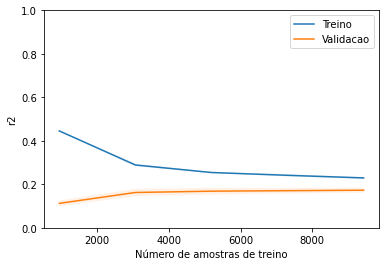

In [39]:
aprendizagem(xgb.XGBRegressor(n_estimators=study.best_params['xg_n_estimators'],max_depth=study.best_params['xg_max_depth']),'r2',0,1)

Variable: T0                   Importance: 0.7300000190734863
Variable: P0                   Importance: 0.18000000715255737
Variable: FCO20/FCH40          Importance: 0.05000000074505806
Variable: FH20                 Importance: 0.03999999910593033


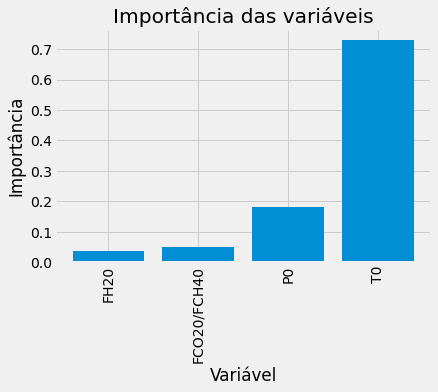

importancia
FH20            0.037626
FCO20/FCH40     0.051616
P0              0.181196
T0              0.729562

In [40]:
df_ipc = importancia(list(X.columns),m,Y)
df_ipc

## Modelo 3

In [19]:
label_dados = list(dados1.columns)

In [20]:
saida_dados = list(dados1[label_dados[4:]].columns)
saida_dados

['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2']

In [21]:
# Dividindo os dados
X,Y = dividir_X_Y(dados1,saida_dados)
Y.columns

Index(['XCH4', 'FH2w', 'FH2', 'XCO2', 'P', 'FCH4', 'FCO2'], dtype='object')

In [22]:
Y = Y['P']

In [23]:
#Separação de Treino, teste e validação
X_Train,X_Test,X_Val,Y_Train,Y_Test,Y_Val = separacao(X,Y,0.1,0.2)

In [24]:
X_Train = X_Train.reset_index(drop=True)
X_Val = X_Val.reset_index(drop=True)
X_Test = X_Test.reset_index(drop=True)
Y_Train = Y_Train.reset_index(drop=True)
Y_Val = Y_Val.reset_index(drop=True)
Y_Test = Y_Test.reset_index(drop=True)

In [25]:

study = otimiza(100)

[I 2021-05-14 06:22:20,268] A new study created in memory with name: no-name-ab15b44d-1b42-4b53-a8dd-7f82a39e17c0


[06:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9646	validation_0-rmse:19.2256	validation_1-error:-20.5385	validation_1-mae:18.9352	validation_1-rmse:19.2068
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0696	validation_0-rmse:17.347	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3301
[2]	validation_0-error:-20.5701	validation_0-mae:15.364	validation_0-rmse:15.6605	validation_1-error:-20.5385	validation_1-mae:15.3375	validation_1-rmse:15.6458
[3]	validation_0-error:-20.5701	validation_0-mae:13.8289	validation_0-rmse:14.1476	validation_1-error:-20.5385	validation_1-mae:13.804	validation_1-rmse:14.1353
[4]	validation_0-error:-20.5701	validation_0-mae:12.4473	validation_0

[I 2021-05-14 06:22:21,691] Trial 0 finished with value: 0.28847641175826644 and parameters: {'xg_n_estimators': 88, 'xg_max_depth': 4}. Best is trial 0 with value: 0.28847641175826644.


[06:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:23,508] Trial 1 finished with value: 0.27015157775035514 and parameters: {'xg_n_estimators': 87, 'xg_max_depth': 9}. Best is trial 0 with value: 0.28847641175826644.


[06:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:26,065] Trial 2 finished with value: 0.227068366064188 and parameters: {'xg_n_estimators': 113, 'xg_max_depth': 16}. Best is trial 0 with value: 0.28847641175826644.


[06:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:27,806] Trial 3 finished with value: 0.28133566474260907 and parameters: {'xg_n_estimators': 150, 'xg_max_depth': 7}. Best is trial 0 with value: 0.28847641175826644.


[06:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9646	validation_0-rmse:19.2256	validation_1-error:-20.5385	validation_1-mae:18.9352	validation_1-rmse:19.2068
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0696	validation_0-rmse:17.347	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3301
[2]	validation_0-error:-20.5701	validation_0-mae:15.364	validation_0-rmse:15.6605	validation_1-error:-20.5385	validation_1-mae:15.3375	validation_1-rmse:15.6458
[3]	validation_0-error:-20.5701	validation_0-mae:13.8289	validation_0-rmse:14.1476	validation_1-error:-20.5385	validation_1-mae:13.804	validation_1-rmse:14.1353
[4]	validation_0-error:-20.5701	validation_0-mae:12.4473	validation_0

[I 2021-05-14 06:22:29,149] Trial 4 finished with value: 0.28847641175826644 and parameters: {'xg_n_estimators': 163, 'xg_max_depth': 4}. Best is trial 0 with value: 0.28847641175826644.


[06:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:30,968] Trial 5 finished with value: 0.28133566474260907 and parameters: {'xg_n_estimators': 160, 'xg_max_depth': 7}. Best is trial 0 with value: 0.28847641175826644.


[06:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:22:32,407] Trial 6 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 193, 'xg_max_depth': 3}. Best is trial 6 with value: 0.2901629865722103.


[06:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:34,070] Trial 7 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 119, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:36,071] Trial 8 finished with value: 0.27621379124264833 and parameters: {'xg_n_estimators': 172, 'xg_max_depth': 8}. Best is trial 7 with value: 0.29191358025504877.


[06:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:22:39,349] Trial 9 finished with value: 0.21277385464763177 and parameters: {'xg_n_estimators': 132, 'xg_max_depth': 22}. Best is trial 7 with value: 0.29191358025504877.


[06:22:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:40,323] Trial 10 finished with value: 0.2911542367393761 and parameters: {'xg_n_estimators': 57, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:41,286] Trial 11 finished with value: 0.2911542367393761 and parameters: {'xg_n_estimators': 57, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:42,278] Trial 12 finished with value: 0.2911542367393761 and parameters: {'xg_n_estimators': 57, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:43,748] Trial 13 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 88, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:22:45,293] Trial 14 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 100, 'xg_max_depth': 3}. Best is trial 7 with value: 0.29191358025504877.


[06:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:47,117] Trial 15 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 126, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:48,463] Trial 16 finished with value: 0.29185373928672376 and parameters: {'xg_n_estimators': 75, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:50,275] Trial 17 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 109, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:52,092] Trial 18 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 136, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:53,912] Trial 19 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 138, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.8299	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8028	validation_1-rmse:14.1321
[4]	validation_0-error:-20.5701	validation_0-mae:12.4483	validation

[I 2021-05-14 06:22:55,717] Trial 20 finished with value: 0.2855366788719834 and parameters: {'xg_n_estimators': 109, 'xg_max_depth': 5}. Best is trial 7 with value: 0.29191358025504877.


[06:22:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:22:57,296] Trial 21 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 140, 'xg_max_depth': 3}. Best is trial 7 with value: 0.29191358025504877.


[06:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:22:59,178] Trial 22 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 142, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:01,052] Trial 23 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 181, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:02,975] Trial 24 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 190, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:04,916] Trial 25 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 193, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:06,861] Trial 26 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 177, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:23:08,549] Trial 27 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 199, 'xg_max_depth': 3}. Best is trial 7 with value: 0.29191358025504877.


[06:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.965	validation_0-rmse:19.2255	validation_1-error:-20.5385	validation_1-mae:18.9355	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0702	validation_0-rmse:17.3468	validation_1-error:-20.5385	validation_1-mae:17.0416	validation_1-rmse:17.3293
[2]	validation_0-error:-20.5701	validation_0-mae:15.3649	validation_0-rmse:15.6601	validation_1-error:-20.5385	validation_1-mae:15.3366	validation_1-rmse:15.6436
[3]	validation_0-error:-20.5701	validation_0-mae:13.83	validation_0-rmse:14.1469	validation_1-error:-20.5385	validation_1-mae:13.8026	validation_1-rmse:14.132
[4]	validation_0-error:-20.5701	validation_0-mae:12.4484	validation_0-

[I 2021-05-14 06:23:10,970] Trial 28 finished with value: 0.2614558635537927 and parameters: {'xg_n_estimators': 189, 'xg_max_depth': 11}. Best is trial 7 with value: 0.29191358025504877.


[06:23:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:12,745] Trial 29 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 94, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:14,813] Trial 30 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 128, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:16,866] Trial 31 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:18,235] Trial 32 finished with value: 0.29181944395762804 and parameters: {'xg_n_estimators': 68, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:19,842] Trial 33 finished with value: 0.29185373928672376 and parameters: {'xg_n_estimators': 80, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:21,773] Trial 34 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 98, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:23,780] Trial 35 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 101, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9646	validation_0-rmse:19.2256	validation_1-error:-20.5385	validation_1-mae:18.9352	validation_1-rmse:19.2068
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.0696	validation_0-rmse:17.347	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3301
[2]	validation_0-error:-20.5701	validation_0-mae:15.364	validation_0-rmse:15.6605	validation_1-error:-20.5385	validation_1-mae:15.3375	validation_1-rmse:15.6458
[3]	validation_0-error:-20.5701	validation_0-mae:13.8289	validation_0-rmse:14.1476	validation_1-error:-20.5385	validation_1-mae:13.804	validation_1-rmse:14.1353
[4]	validation_0-error:-20.5701	validation_0-mae:12.4473	validation_0

[I 2021-05-14 06:23:25,513] Trial 36 finished with value: 0.28847641175826644 and parameters: {'xg_n_estimators': 112, 'xg_max_depth': 4}. Best is trial 7 with value: 0.29191358025504877.


[06:23:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:27,635] Trial 37 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 155, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:29,658] Trial 38 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 101, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:31,857] Trial 39 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 118, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:23:33,721] Trial 40 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 152, 'xg_max_depth': 3}. Best is trial 7 with value: 0.29191358025504877.


[06:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:35,926] Trial 41 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 172, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:38,150] Trial 42 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 200, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9643	validation_0-rmse:19.2259	validation_1-error:-20.5385	validation_1-mae:18.9343	validation_1-rmse:19.2066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.069	validation_0-rmse:17.3478	validation_1-error:-20.5385	validation_1-mae:17.0404	validation_1-rmse:17.3304
[2]	validation_0-error:-20.5701	validation_0-mae:15.363	validation_0-rmse:15.6619	validation_1-error:-20.5385	validation_1-mae:15.3357	validation_1-rmse:15.6465
[3]	validation_0-error:-20.5701	validation_0-mae:13.8276	validation_0-rmse:14.1497	validation_1-error:-20.5385	validation_1-mae:13.8014	validation_1-rmse:14.1358
[4]	validation_0-error:-20.5701	validation_0-mae:12.4456	validation_

[I 2021-05-14 06:23:40,041] Trial 43 finished with value: 0.2901629865722103 and parameters: {'xg_n_estimators': 189, 'xg_max_depth': 3}. Best is trial 7 with value: 0.29191358025504877.


[06:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:42,277] Trial 44 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 137, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:44,489] Trial 45 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 181, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:46,807] Trial 46 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 168, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:49,153] Trial 47 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 183, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:51,354] Trial 48 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 168, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:53,801] Trial 49 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 195, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:56,044] Trial 50 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 162, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:23:58,476] Trial 51 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 191, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:00,870] Trial 52 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 160, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:03,283] Trial 53 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 176, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:05,638] Trial 54 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 178, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:07,983] Trial 55 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 197, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:10,369] Trial 56 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 144, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:12,743] Trial 57 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 187, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:15,266] Trial 58 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 185, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:17,513] Trial 59 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 94, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:19,809] Trial 60 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 128, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:22,211] Trial 61 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 103, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:24,583] Trial 62 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 121, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:26,976] Trial 63 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 104, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:29,431] Trial 64 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 116, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:31,798] Trial 65 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 166, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:34,362] Trial 66 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 170, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:36,923] Trial 67 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 197, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:39,457] Trial 68 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 193, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:41,903] Trial 69 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 154, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:44,444] Trial 70 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 134, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:46,777] Trial 71 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 146, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:48,708] Trial 72 finished with value: 0.29185373928672376 and parameters: {'xg_n_estimators': 82, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:51,014] Trial 73 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 97, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:53,309] Trial 74 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 100, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:55,657] Trial 75 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 162, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:24:57,961] Trial 76 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 156, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:24:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:00,420] Trial 77 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 176, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:02,751] Trial 78 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 196, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:05,058] Trial 79 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 148, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:07,301] Trial 80 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 158, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:09,651] Trial 81 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 166, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:11,948] Trial 82 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 170, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:14,272] Trial 83 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 175, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:16,547] Trial 84 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 187, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:19,014] Trial 85 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 199, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:21,429] Trial 86 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 185, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:23,976] Trial 87 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 136, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:26,341] Trial 88 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 121, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:28,762] Trial 89 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 132, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:31,224] Trial 90 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 106, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:33,736] Trial 91 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 116, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:36,097] Trial 92 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 105, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:38,433] Trial 93 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 93, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:41,110] Trial 94 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 112, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:43,663] Trial 95 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 123, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:46,026] Trial 96 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 129, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:48,533] Trial 97 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 106, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:50,925] Trial 98 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 166, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


[06:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

[I 2021-05-14 06:25:53,404] Trial 99 finished with value: 0.29191358025504877 and parameters: {'xg_n_estimators': 115, 'xg_max_depth': 2}. Best is trial 7 with value: 0.29191358025504877.


In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
m,Y_Train_pred,Y_Val_pred,Y_Test_pred =  melhor_modelo(study)

[06:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-20.5701	validation_0-mae:18.9637	validation_0-rmse:19.2274	validation_1-error:-20.5385	validation_1-mae:18.9349	validation_1-rmse:19.2087
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-error:-20.5701	validation_0-mae:17.068	validation_0-rmse:17.3508	validation_1-error:-20.5385	validation_1-mae:17.0414	validation_1-rmse:17.3347
[2]	validation_0-error:-20.5701	validation_0-mae:15.3617	validation_0-rmse:15.6667	validation_1-error:-20.5385	validation_1-mae:15.3365	validation_1-rmse:15.6525
[3]	validation_0-error:-20.5701	validation_0-mae:13.8261	validation_0-rmse:14.1562	validation_1-error:-20.5385	validation_1-mae:13.8021	validation_1-rmse:14.144
[4]	validation_0-error:-20.5701	validation_0-mae:12.4439	validation_

In [28]:
desemp = desempenho(Y_Train, Y_Train_pred,Y_Val, Y_Val_pred, Y_Test, Y_Test_pred)
desemp

MAE        R2       MSE      RMSE
Train       2.185935  0.285262  7.493185  2.737368
Validation  2.219825  0.291914  7.714784  2.777550
Test        2.201510  0.276447  7.645962  2.765133

[06:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

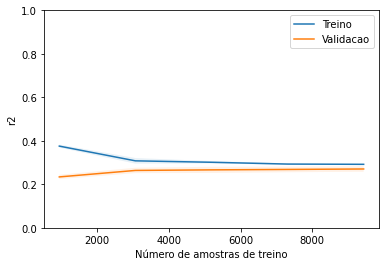

In [29]:
aprendizagem(xgb.XGBRegressor(n_estimators=study.best_params['xg_n_estimators'],max_depth=study.best_params['xg_max_depth']),'r2',0,1)

Variable: P0                   Importance: 0.7400000095367432
Variable: T0                   Importance: 0.23000000417232513
Variable: FH20                 Importance: 0.019999999552965164
Variable: FCO20/FCH40          Importance: 0.019999999552965164


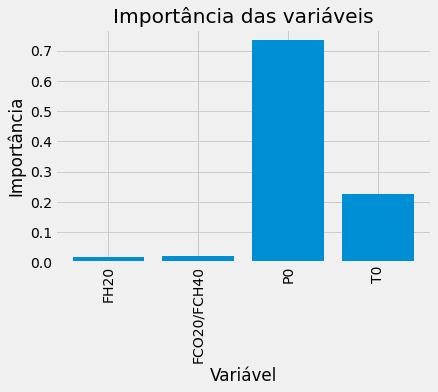

importancia
FH20            0.017587
FCO20/FCH40     0.021296
P0              0.735301
T0              0.225816

In [30]:
df_ipc = importancia(list(X.columns),m,Y)
df_ipc

## Modelo 4